## Reading Data

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
os.chdir('..')

In [3]:
os.getcwd()

'c:\\Users\\iiven\\Ai-Cursor\\Chest X-Ray'

In [4]:
def  Data(train_path):
    classes, class_paths = zip(*[(label, os.path.join(train_path, label, image))
                                for label in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, label))
                                for image in os.listdir(os.path.join(train_path, label))])
    Data = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return Data

In [5]:
df = Data('Data/All_Data')

In [6]:
df.head()

,Class Path,Class
0,Data/All_Data\NORMAL\IM-0001-0001.jpeg,NORMAL
1,Data/All_Data\NORMAL\IM-0003-0001.jpeg,NORMAL
2,Data/All_Data\NORMAL\IM-0005-0001.jpeg,NORMAL
3,Data/All_Data\NORMAL\IM-0006-0001.jpeg,NORMAL
4,Data/All_Data\NORMAL\IM-0007-0001.jpeg,NORMAL


In [7]:
df.tail()

,Class Path,Class
9993,Data/All_Data\PNEUMONIA\PNEUMONIA_original_per...,PNEUMONIA
9994,Data/All_Data\PNEUMONIA\PNEUMONIA_original_per...,PNEUMONIA
9995,Data/All_Data\PNEUMONIA\PNEUMONIA_original_per...,PNEUMONIA
9996,Data/All_Data\PNEUMONIA\PNEUMONIA_original_per...,PNEUMONIA
9997,Data/All_Data\PNEUMONIA\PNEUMONIA_original_per...,PNEUMONIA


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

In [9]:
import pickle
with open('Data/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)


In [14]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df['Class'])

## Data loader

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [16]:
class ChestXrayDataset(Dataset):
    def __init__(self, DataFrame, transform=None):
        self.data = DataFrame
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name).convert('L')  # Convert to grayscale
        label = int(self.data.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # for grayscale images
])

In [18]:
train_dataset = ChestXrayDataset(DataFrame= df_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

## Model NN

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ChestXrayCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ChestXrayCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChestXrayCNN(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [21]:
device

device(type='cuda')

In [22]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Update tqdm description with batch loss
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch 1/10: 100%|██████████| 625/625 [01:45<00:00,  5.92it/s, Batch Loss=0.534]  


Epoch [1/10], Loss: 0.2244


Epoch 2/10: 100%|██████████| 625/625 [01:47<00:00,  5.79it/s, Batch Loss=0.143]  


Epoch [2/10], Loss: 0.1368


Epoch 3/10: 100%|██████████| 625/625 [01:47<00:00,  5.83it/s, Batch Loss=0.123]  


Epoch [3/10], Loss: 0.0991


Epoch 4/10: 100%|██████████| 625/625 [01:45<00:00,  5.91it/s, Batch Loss=0.121]   


Epoch [4/10], Loss: 0.0718


Epoch 5/10: 100%|██████████| 625/625 [01:44<00:00,  5.96it/s, Batch Loss=0.106]   


Epoch [5/10], Loss: 0.0514


Epoch 6/10: 100%|██████████| 625/625 [01:45<00:00,  5.90it/s, Batch Loss=0.00627] 


Epoch [6/10], Loss: 0.0339


Epoch 7/10: 100%|██████████| 625/625 [01:47<00:00,  5.83it/s, Batch Loss=0.418]   


Epoch [7/10], Loss: 0.0251


Epoch 8/10: 100%|██████████| 625/625 [01:47<00:00,  5.84it/s, Batch Loss=0.00177] 


Epoch [8/10], Loss: 0.0220


Epoch 9/10: 100%|██████████| 625/625 [01:48<00:00,  5.79it/s, Batch Loss=4.45e-5] 


Epoch [9/10], Loss: 0.0153


Epoch 10/10: 100%|██████████| 625/625 [01:45<00:00,  5.92it/s, Batch Loss=0.00101] 

Epoch [10/10], Loss: 0.0128


## Evaluation

In [23]:
test_dataset = ChestXrayDataset(DataFrame= df_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [24]:
def evaluate(model, data_loader, criterion):
    model.eval()  # Evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)  # Get predicted class
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    print(f"Evaluation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


In [25]:
evaluate(model, test_loader, criterion)

Evaluation Loss: 0.0736, Accuracy: 97.40%


In [26]:
from sklearn.metrics import classification_report

def evaluate_classification_report(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=['NORMAL', 'PNEUMONIA'])
    print(report)


In [27]:
evaluate_classification_report(model, test_loader)

              precision    recall  f1-score   support

      NORMAL       1.00      0.95      0.97      1000
   PNEUMONIA       0.95      1.00      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.98      0.97      0.97      2000
weighted avg       0.98      0.97      0.97      2000



In [28]:
print(model)

ChestXrayCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_confusion_matrix(model, data_loader, class_names=['NORMAL', 'PNEUMONIA']):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # forward pass

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


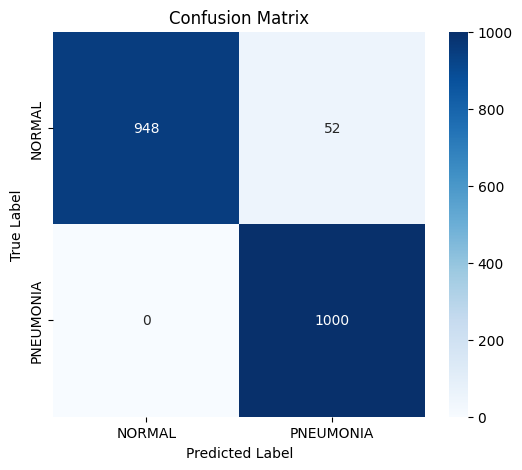

In [30]:
evaluate_confusion_matrix(model, test_loader)

In [31]:
torch.save(model.state_dict(), 'chest_xray_CNN_from_skratch_weights.pth')

## Inference

In [1]:
import os
os.chdir('..')

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class ChestXrayCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ChestXrayCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [3]:
%pwd

'c:\\Users\\iiven\\Ai-Cursor\\Chest X-Ray'

C:\Users\iiven\AppData\Local\Temp\ipykernel_2832\4053518273.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('chest_xray_CNN_from_skratc

Predicted class: PNEUMONIA, Confidence: 1.0000


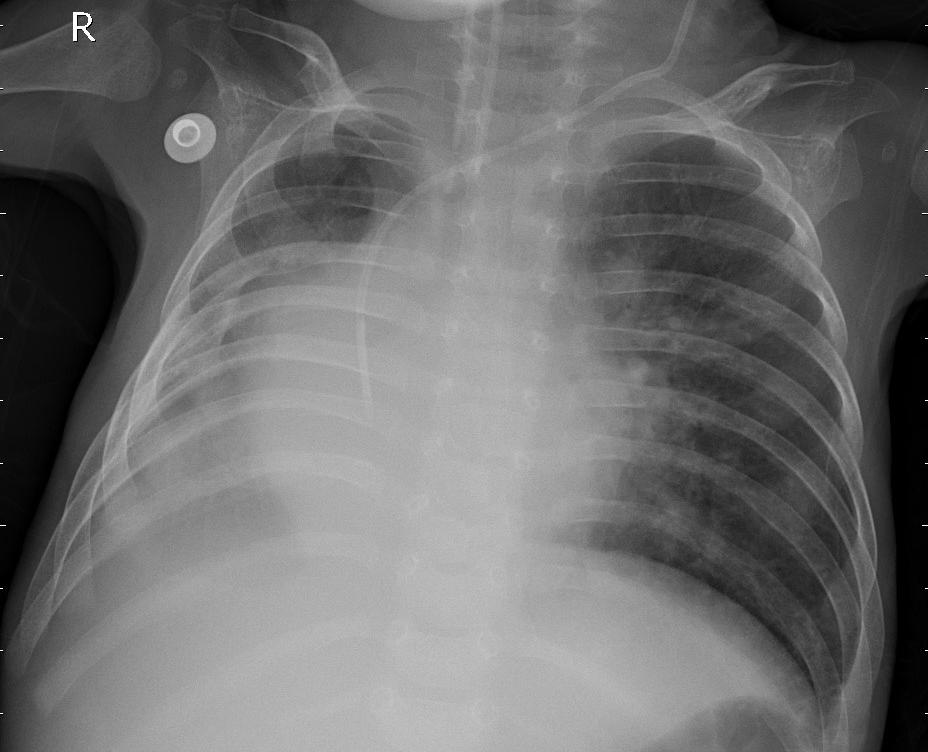

In [5]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from IPython.display import display
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the full model (architecture + weights)
model = ChestXrayCNN(num_classes= 2)
model.to(device)
model.load_state_dict(torch.load('chest_xray_CNN_from_skratch_weights.pth', map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # for grayscale images
])


img_path = "Data\PNEUMONIA\person6_bacteria_22.jpeg"
image = Image.open(img_path).convert('L')
input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)
    probs = torch.sigmoid(output)
    pred_class = torch.argmax(probs, dim=1).item()

with open('Data/label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)
predicted_label = le.inverse_transform([pred_class])[0]
print(f"Predicted class: {predicted_label}, Confidence: {probs[0][pred_class]:.4f}")
display(image)